In [ ]:
!pip install umap-learn

     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 22.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=79baee66133fd8e762305677112a02d5ce4a8fb411fdee965b68146bcf12bb27
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=62b6974d816c4ce86e5c8604af8ec24c305bb0c455f243d8e001731f7b36e069
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
!pip install keras==2.1.6

In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import roc_curve,roc_auc_score
# import umap.umap_ as umap
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load in data

In [5]:
# training data with all labels
train = pd.read_csv('/content/gdrive/MyDrive/BMI707 Project/TRAINING_notes_padded.csv',
                    index_col=0)
# val data with all labels
val = pd.read_csv('/content/gdrive/MyDrive/BMI707 Project/VALDIATION_notes_padded.csv',
                   index_col=0)
# test data with binary labels
test = pd.read_csv('/content/gdrive/MyDrive/BMI707 Project/padded_notes_testNEW.csv',
                   index_col=0)
# test data with multi class labels
multi_test = pd.read_csv("/content/gdrive/MyDrive/BMI707 Project/test_data_balanced.csv")

In [ ]:
# check data fields
train.columns

Index(['token1', 'token2', 'token3', 'token4', 'token5', 'token6', 'token7',
       'token8', 'token9', 'token10',
       ...
       'token506', 'token507', 'token508', 'token509', 'token510', 'token511',
       'token512', 'binary_outcome', 'outcome_count', 'ID'],
      dtype='object', length=515)

In [ ]:
val.columns

Index(['token1', 'token2', 'token3', 'token4', 'token5', 'token6', 'token7',
       'token8', 'token9', 'token10',
       ...
       'token506', 'token507', 'token508', 'token509', 'token510', 'token511',
       'token512', 'binary_outcome', 'outcome_count', 'ID'],
      dtype='object', length=515)

In [ ]:
test.columns

Index(['token1', 'token2', 'token3', 'token4', 'token5', 'token6', 'token7',
       'token8', 'token9', 'token10',
       ...
       'token504', 'token505', 'token506', 'token507', 'token508', 'token509',
       'token510', 'token511', 'token512', 'binary_outcome'],
      dtype='object', length=513)

In [ ]:
multi_test.columns

Index(['ROW_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY',
       'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'outcome_count',
       'binary_outcome', 'ID'],
      dtype='object')

#### Separate data from labels for train and test sets

In [6]:
num_classes = 2
label_col_num = -3
test_label_col_num = -1
multi_label_col_num = -2

# training set preparation
train = np.array(train)
X_train = train[:,:label_col_num].astype('float32')
y_train = train[:, label_col_num].astype('float32')
y_train_multi = train[:, multi_label_col_num].astype('float32')
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                     test_size=0.2, random_state=42)

# validation set preparation
val = np.array(val)
np.random.shuffle(val)
X_val = val[:,:label_col_num].astype('float32')
y_val = val[:, label_col_num].astype('float32')
y_val_multi = val[:, multi_label_col_num].astype('float32')

# test set preparation (only binary)
test = np.array(test)
X_test = test[:,:test_label_col_num].astype('float32')
y_test = test[:, test_label_col_num].astype('float32')
y_test_multi = np.array(multi_test['outcome_count'])

# one-hot encode multi-class labels:
enc = OneHotEncoder(sparse=False)
y_train_multi = enc.fit_transform(y_train_multi.reshape(-1,1))
y_val_multi = enc.fit_transform(y_val_multi.reshape(-1,1))
y_test_multi = enc.fit_transform(y_test_multi.reshape(-1,1))


print("Train data shape: (%s, %s)" %X_train.shape)
print("Train binary label shape: (%s,)" %y_train.shape)
print("Train multi-label shape: (%s, %s)" %y_train_multi.shape)

print("Validation data shape: (%s, %s)" %X_val.shape)
print("Validation binary label shape: (%s,)" %y_val.shape)
print("Validation multi-label shape: (%s, %s)" %y_val_multi.shape)

print("Test data shape: (%s, %s)" %X_test.shape)
print("Test binary label shape: (%s,)" %y_test.shape)
print("Test multi-label shape: (%s, %s)" %y_test_multi.shape)

Train data shape: (105635, 512)
Train binary label shape: (105635,)
Train multi-label shape: (105635, 6)
Validation data shape: (26056, 512)
Validation binary label shape: (26056,)
Validation multi-label shape: (26056, 6)
Test data shape: (32539, 512)
Test binary label shape: (32539,)
Test multi-label shape: (32539, 6)


In [ ]:
# initialize parameters
seq_len = X_train.shape[-1]
max_words = 10000
vocab_size = max_words + 1
embedding_dim = 100

# Define performance metrics

Functions to evaluate model performance on validation set.
Note: accuracy is probably higher in validation compared to test since test set has out-of-vocab terms.

In [ ]:
def report_metrics(model_name, y_val, y_pred, multi=False):
  if multi: 
    print("%s accuracy: %.5f" %(model_name, accuracy_score(y_val, y_pred)))
    print("%s precision: %.5f" %(model_name, precision_score(y_val, y_pred,
                                                             average='micro')))
    print("%s recall: %.5f" %(model_name, recall_score(y_val, y_pred,
                                                       average='micro')))
    print("%s F1: %.5f" %(model_name, f1_score(y_val, y_pred,
                                               average='micro')))
  else:
    print("%s accuracy: %.5f" %(model_name, accuracy_score(y_val, 
                                                          np.round(y_pred))))
    print("%s precision: %.5f" %(model_name, precision_score(y_val, 
                                                            np.round(y_pred))))
    print("%s recall: %.5f" %(model_name, recall_score(y_val, 
                                                        np.round(y_pred))))
    print("%s F1: %.5f" %(model_name, f1_score(y_val, np.round(y_pred))))
    print("%s AUC: %.5f" %(model_name, roc_auc_score(y_val, y_pred)))
  

# Model #1: Embedding + LSTM

## Binary classification

In [ ]:
# build embedding + LSTM model with functional API
input = K.Input(shape=(seq_len,), 
                dtype='int32',
                name='input')
x = K.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
              name='embedding')(input)
x = K.layers.LSTM(units = 128,
                  name='lstm')(x)
x = K.layers.Dense(256, activation='relu',
                   name='dense')(x)
x = K.layers.Dropout(rate=0.5,
                     name='dropout')(x)
x = K.layers.Dense(units=1, activation='sigmoid', 
                   name='output')(x)

model = K.Model(inputs=input, outputs=x)
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 257       
Total params: 1,150,629
Trainable params: 1,150,629
Non-trainable params: 0
________________________________________________

In [ ]:
# compile and train LSTM
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# define callbacks for early stop
early_stopping_monitor = K.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping_monitor])

Epoch 1/10
826/826 [==============================] - 118s 140ms/step - loss: 0.4822 - accuracy: 0.7600 - val_loss: 0.3929 - val_accuracy: 0.8413
Epoch 2/10
826/826 [==============================] - 114s 139ms/step - loss: 0.2936 - accuracy: 0.8816 - val_loss: 0.3783 - val_accuracy: 0.8312
Epoch 3/10
826/826 [==============================] - 115s 139ms/step - loss: 0.2802 - accuracy: 0.8859 - val_loss: 0.3954 - val_accuracy: 0.8355
Epoch 4/10
826/826 [==============================] - 116s 140ms/step - loss: 0.2514 - accuracy: 0.8996 - val_loss: 0.4554 - val_accuracy: 0.8345
Epoch 5/10
826/826 [==============================] - 116s 140ms/step - loss: 0.2215 - accuracy: 0.9122 - val_loss: 0.4601 - val_accuracy: 0.8337


In [ ]:
# save LSTM model
# model.save("/content/gdrive/MyDrive/BMI707 Project/LSTM_model")

In [3]:
# load model back in if needed
model = load_model("/content/gdrive/MyDrive/BMI707 Project/LSTM_model")

In [ ]:
# convert last layer softmax into linear activation
x = model.layers[-2].output
x = K.layers.Dense(1, activation='linear', name='dense_2')(x)
model = K.Model(model.input, x)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,150,629
Trainable params: 1,150,629
Non-trainable params: 0
_________________________________________________

#### Model evaluation

In [ ]:
# LSTM: make predictions on training data
y_pred = model.predict(X_train) 
report_metrics("LSTM", y_train, y_pred)

LSTM accuracy: 0.89034
LSTM precision: 0.96337
LSTM recall: 0.81252
LSTM F1: 0.88153
LSTM AUC: 0.96114


In [ ]:
# LSTM: make predictions on validation data
y_pred = model.predict(X_val) 
report_metrics("LSTM", y_val, y_pred)

LSTM accuracy: 0.83117
LSTM precision: 0.90969
LSTM recall: 0.73792
LSTM F1: 0.81485
LSTM AUC: 0.90762


In [ ]:
# LSTM: make predictions on test data
y_pred = model.predict(X_test) 
fpr, tpr, _ = roc_curve(y_test, y_pred) 
report_metrics("LSTM", y_test, y_pred)

LSTM accuracy: 0.80897
LSTM precision: 0.89758
LSTM recall: 0.68894
LSTM F1: 0.77954
LSTM AUC: 0.89297


### Interpretation

In [8]:
# get indices of top 5 scoring notes in test set
y_pred = model.predict(X_test)
top_scoring_idx = np.argsort(np.squeeze(y_pred))[-100:]

In [9]:
top_scoring_idx

array([10081,  8715, 15482, 14955,  4885,  8268, 13004, 13181,  9683,
       15898,  6396, 10256,  6297, 12357,  8625, 12374, 11954,  8794,
       15175, 10395, 10823, 14112,  8923,  9539, 12734, 11009, 14002,
       10647, 11735,  5151, 15551,  7879, 13177, 12659, 13969, 11013,
       12968, 10341, 10830,  9418, 12729, 15701,  9797, 11877, 12179,
       14493, 15050, 11464,  9921, 11467, 15716, 13167, 14323, 11371,
       14788, 14124, 13718, 14638, 13987, 10275, 11603, 12032, 10928,
       10390, 10864,  9847,  8202, 15558, 10844, 10810, 15775, 13184,
        7196, 10841, 11647, 12331, 10092, 14907, 10580,  9908,  8130,
       14549, 14806, 12843, 12063, 10384, 15136, 11370, 14958,  9508,
       12842, 14973, 15073, 12463, 15629, 13665,  9705, 15930,  8668,
       15916])

In [10]:
# read in cleaned test notes:
test_notes = pd.read_csv("/content/gdrive/MyDrive/BMI707 Project/test_notes_cleaned.txt",sep='\t',
                         header=None)
test_notes.columns = ["notes"]

In [16]:
test_notes

,notes
0,"['pleural', 'asp', 'radiologist', 'right', 'gu..."
1,"['chest', 'portable', 'ap', 'clip', 'clip', 'n..."
2,"['pm', 'lumbosacral', 'spine', 'ap', 'lat', 'c..."
3,"['chest', 'single', 'view', 'clip', 'clip', 'n..."
4,"['chest', 'portable', 'ap', 'clip', 'clip', 'n..."
...,...
32534,"['pm', 'babygram', 'chest', 'distinct', 'proce..."
32535,"['pm', 'femur', 'ap', 'lat', 'leave', 'clip', ..."
32536,"['ct', 'chest', 'wwo', 'c', 'ct', 'nonionic', ..."
32537,"['pm', 'babygram', 'chest', 'clip', 'clip', 'n..."


In [11]:
# print top 5 notes:
for i in test_notes.loc[top_scoring_idx, "notes"]:
  print(i)

['chest', 'portable', 'ap', 'clip', 'clip', 'number', 'radiology', 'reason', 'please', 'eval', 'interval', 'change', 'admit', 'diagnosis', 'hypoxia', 'hospital', 'medical', 'condition', 'year', 'old', 'woman', 'sepsis', 'pulm', 'edema', 'reason', 'examination', 'please', 'eval', 'interval', 'change', 'provisional', 'finding', 'impression', 'pfi', 'dlnc', 'wed', 'worsen', 'leave', 'upper', 'lobe', 'opacity', 'give', 'patchy', 'pattern', 'abnormality', 'may', 'represent', 'combination', 'pulmonary', 'edema', 'infection', 'please', 'correlate', 'clinically', 'final', 'report', 'reason', 'examination', 'followup', 'patient', 'pulmonary', 'edema', 'sepsis', 'portable', 'ap', 'chest', 'radiograph', 'compare', 'obtain', 'et', 'tube', 'tip', 'cm', 'carina', 'ng', 'tube', 'tip', 'stomach', 'right', 'internal', 'jugular', 'line', 'tip', 'cavoatrial', 'junction', 'cardiomediastinal', 'silhouette', 'grossly', 'unchanged', 'interval', 'worsen', 'leave', 'upper', 'lobe', 'consolidation', 'change', '

In [15]:
# calculate number of notes with "sepsis" among top 100 test instances
np.sum(np.array(["sepsis" in note for note in test_notes.loc[top_scoring_idx, "notes"]]))

34

In [19]:
contains_sepsis = np.array(["sepsis" in note for note in test_notes["notes"]])

In [23]:
preds_contains_sepsis = model.predict(X_test[contains_sepsis == True])
preds_no_sepsis = model.predict(X_test[contains_sepsis == False])

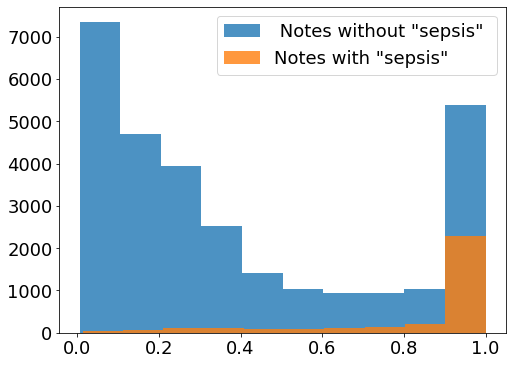

In [33]:
rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8,6))
plt.hist(preds_no_sepsis, alpha=0.8)
plt.hist(preds_contains_sepsis, alpha=0.8)
plt.legend([" Notes without \"sepsis\" ",  "Notes with \"sepsis\""])
plt.show()

A little more human readable:
1. pm unilat ext vein u right clip clip number radiology reason swell eval dvt etc rue admit diagnosis acute renal failure hospital medical condition year old man urosepsis mrsa pna sp stemi w respiratory failure rue swell near hd line reason examination eval dvt etc rue wet read enya fri pm occlusive r cephalic v clot cephalic v consider deep vein clot r ij subclavian axillary brachial basilic v final report history man urosepsis mrsa right upper extremity edema comparison none finding color doctor last name sonname ni perform right upper extremity right cephalic vein note complete occlusive clot however right internal jugular axillary brachial basilic vein normal compressibility augmentation waveform right subclavian vein patent impression occlusive clot right cephalic vein note cephalic vein superficial vein otherwise deep vein thrombosis right upper extremity sesha

2. pm chest portable ap physician name initial pre clip number radiology reason assess pulmonary edema hospital medical condition year old woman hypoxia ivf resuscitation reason examination ass pulmonary edema final report portable chest radiograph perform comparison make earlier chest radiograph date clinical history woman hypoxia ivf resuscitation evaluate pulmonary edema finding single ap portable chest radiograph obtain interval increase pulmonary vascular congestion compatible fluid overload blunt right cp angle may correspond small pleural effusion bibasilar atelectasis also note cardiomediastinal silhouette grossly unchanged pulmonary hilar engorgement also note osseous structure intact impression interval development pulmonary vascular congestion compatible fluid overload small right pleural effusion bibasilar atelectasis sesha

3. ct abd pelvis contrast clip clip number radiology reason please use po iv contrast ass fluid collection admit diagnosis cholangiocarcinomasda hospital medical condition w cholangiocarcinoma distal cbd w metastasis rt hepatic lobe sp whipple rt lobectomy cb pancreatic leak febrile elevate wbc reason examination please use po iv contrast ass fluid collection contraindication iv contrast final report indication history distal cholangiocarcinoma right hepatic lobectomy whipple perform complicate pancreatic leak patient febrile elevate white count subdiaphragmatic fluid collection identify prior ct technique mdct image obtain lung base pelvic outlet administration intravenous contrast coronal sagittal reformation acquire dlp mgycm comparison cta chest ctabdomen pelvis ct abdomen subdiaphragmatic airfluid collection enlarge though two catheter still place measursing approximately x cm several new focus air near pacreaticjejunal anastamoss peripancreatic fluid collection worsen measure x cm pancreatic stent longer visualized duct may locate small bowel extravasation oral contrast new small fluid collection hepatic flexure leave lobe liver enhance homogeneously hepatic portal vein patent worsen abdominal ascites leave pleural effusion resolve right pleural effusion stable bibasilar atelectasis unchanged visualized portion heart pericardium unremarkable stomach distal small bowel within normal limit kidney enhance symmetrically excrete contrast without evidence hydronephrosis mass adrenal gland unremarkable prominent mesenteric retroperitoneal lymph node unchanged ct pelvis distal ureter urinary bladder seminal vesicle prostate rectum sigmoid colon within normal limit pelvic lymphadenopathy osseous structure lytic blastic lesion suspicious metastatic disease impression enlarge subdiaphragmatic peripancreatic fluid collection locules air worsen ascites concern underlying anastomotic ct abd pelvis contrast clip clip number radiology reason please use po iv contrast ass fluid collection admit diagnosis cholangiocarcinomasda final report cont leak two subdiaphragmatic drain stable position decrease left pleural effusion finding discuss dr first name stitle name stitle dr first last name phone pm mjmgb

4. chest portable ap clip clip number radiology reason pls ass interval change admit diagnosis ascitesedema hospital medical condition year old woman hep c cirrhosis r hydrothorax pulm edema intubate reason examination pls ass interval change final report chest radiograph indication evaluation interval change comparison compare previous examination endotracheal tube retract tip cm carina monitor support device unchanged unchanged pleural effusion bibasilar atelectasis mild cardiomegaly well sign moderate overhydration

5. chest portable ap clip clip number radiology reason fluid overload pneumonia admit diagnosis cellulitis hospital medical condition year old man fluid overload hep c cirrhosis esrd hd reason examination fluid overload pneumonia final report indication history hepatitis c endstage renal disease hemodialysis evaluation sign fluid overload pneumonia comparison multiple prior finding leave ij doublelumen catheter terminates low svc right atrium persistent bibasilar atelectasis small leave pleural effusion unchanged cardiomediastinal silhouette stable mjmgb

## Multi-class classication

In [ ]:
!pip install --upgrade tensorflow keras

     |████████████████████████████████| 394.3MB 40kB/s 
     |████████████████████████████████| 6.0MB 38.7MB/s 
     |████████████████████████████████| 471kB 35.9MB/s 
     |████████████████████████████████| 3.9MB 34.9MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
  Found existing installation: Keras 2.2.2
    Uninstalling Keras-2.2.2:
      Successfully uninstalled Keras-2.2.2


In [ ]:
# copy all layers from binary classifier LSTM up until output neuron 
x = model.get_layer('dropout').output
multi_preds = K.layers.Dense(6, activation='softmax',
                            name='output')(x)  # add new multi-class output 
multi_model = K.Model(model.get_layer('input').output, multi_preds)

multi_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 6)                 1542      
Total params: 1,151,914
Trainable params: 1,151,914
Non-trainable params: 0
________________________________________________

In [ ]:
# compile and train multi-label LSTM
multi_model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


multi_history = multi_model.fit(X_train, y_train_multi,
          batch_size=128,
          epochs=10,
          validation_data=(X_val, y_val_multi),
          callbacks=[early_stopping_monitor])

Epoch 1/10
826/826 [==============================] - 118s 141ms/step - loss: 1.0359 - accuracy: 0.5974 - val_loss: 0.9400 - val_accuracy: 0.6362
Epoch 2/10
826/826 [==============================] - 115s 139ms/step - loss: 0.7902 - accuracy: 0.6764 - val_loss: 0.9405 - val_accuracy: 0.6314
Epoch 3/10
826/826 [==============================] - 115s 139ms/step - loss: 0.7159 - accuracy: 0.7068 - val_loss: 1.0016 - val_accuracy: 0.6287
Epoch 4/10
826/826 [==============================] - 115s 139ms/step - loss: 0.6201 - accuracy: 0.7521 - val_loss: 1.0550 - val_accuracy: 0.6280


In [ ]:
# save LSTM multi-class model
multi_model.save("/content/gdrive/MyDrive/BMI707 Project/LSTM_multi_model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BMI707 Project/LSTM_multi_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BMI707 Project/LSTM_multi_model/assets


In [ ]:
# load model
# multi_model = K.models.load_model("/content/gdrive/MyDrive/BMI707/LSTM_multi_model")

#### Model evaluation

In [ ]:
# LSTM multi-class eval on train set
y_pred = multi_model.predict(X_train)

metrics_dict = {"Accuracy": K.metrics.CategoricalAccuracy(),
 "Precision": K.metrics.Precision(),
 "Recall": K.metrics.Recall()}

metrics = []
for key in metrics_dict:
  m = metrics_dict[key]
  m.update_state(y_train_multi, y_pred)
  metrics.append(m.result().numpy())
  print("LSTM multi-class %s: %.5f" %(key, m.result().numpy()))

print("LSTM multi-class F1: %.5f" %((2*metrics[1]*metrics[2]) / 
                                    (metrics[1]+metrics[2])))

LSTM multi-class Accuracy: 0.67330
LSTM multi-class Precision: 0.75704
LSTM multi-class Recall: 0.53858
LSTM multi-class F1: 0.62939


In [ ]:
# LSTM multi-class eval on validation set
y_pred = multi_model.predict(X_val)

metrics = []
for key in metrics_dict:
  m = metrics_dict[key]
  m.update_state(y_val_multi, y_pred)
  metrics.append(m.result().numpy())
  print("LSTM multi-class %s: %.5f" %(key, m.result().numpy()))

print("LSTM multi-class F1: %.5f" %((2*metrics[1]*metrics[2]) / 
                                    (metrics[1]+metrics[2])))

LSTM multi-class Accuracy: 0.66596
LSTM multi-class Precision: 0.75330
LSTM multi-class Recall: 0.53282
LSTM multi-class F1: 0.62416


In [ ]:
# LSTM multi-class eval on test set
y_pred = multi_model.predict(X_test)

metrics = []
for key in metrics_dict:
  m = metrics_dict[key]
  m.update_state(y_test_multi, y_pred)
  metrics.append(m.result().numpy())
  print("LSTM multi-class %s: %.5f" %(key, m.result().numpy()))

print("LSTM multi-class F1: %.5f" %((2*metrics[1]*metrics[2]) / 
                                    (metrics[1]+metrics[2])))

LSTM multi-class Accuracy: 0.65935
LSTM multi-class Precision: 0.74528
LSTM multi-class Recall: 0.52861
LSTM multi-class F1: 0.61852


# Model #2: Embedding + GRU

## Binary classification

In [ ]:
# build embedding + GRU model
input2 = K.Input(shape=(seq_len,), dtype='int32', 
                 name = 'input')
x2 = K.layers.Embedding(input_dim = vocab_size, 
                        output_dim = embedding_dim, 
                        name='embedding')(input2)
x2 = K.layers.GRU(units = 128, name = 'gru')(x2)
x2 = K.layers.Dense(units=1, activation='sigmoid', 
                   name='output')(x2)

model2 = K.Model(inputs=input2, outputs=x2)
model2.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000100   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 1,088,549
Trainable params: 1,088,549
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile and train GRU
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(X_val, y_val))

Epoch 1/5
824/824 [==============================] - 48s 57ms/step - loss: 0.5135 - accuracy: 0.7361 - val_loss: 0.3344 - val_accuracy: 0.8604
Epoch 2/5
824/824 [==============================] - 47s 56ms/step - loss: 0.3028 - accuracy: 0.8783 - val_loss: 0.2766 - val_accuracy: 0.8826
Epoch 3/5
824/824 [==============================] - 46s 56ms/step - loss: 0.2367 - accuracy: 0.9039 - val_loss: 0.2665 - val_accuracy: 0.8899
Epoch 4/5
824/824 [==============================] - 46s 56ms/step - loss: 0.2090 - accuracy: 0.9146 - val_loss: 0.2658 - val_accuracy: 0.8903
Epoch 5/5
824/824 [==============================] - 46s 56ms/step - loss: 0.1849 - accuracy: 0.9244 - val_loss: 0.2606 - val_accuracy: 0.8893


### Model evaluation

In [ ]:
# GRU predict on validation data
y_pred = model2.predict(X_val)
fpr2, tpr2, _ = roc_curve(y_val[:,1], y_pred[:,1])    
report_metrics("GRU", y_pred)

GRU accuracy: 0.88967
GRU precision: 0.92149
GRU recall: 0.85543
GRU F1: 0.88723
GRU AUC: 0.95644


# Model #3: Embedding + Conv1D

## Binary classification

In [ ]:
# build embedding + conv1D model
input3 = K.Input(shape=(seq_len,), dtype='int32',
                 name="input")
x3 = K.layers.Embedding(vocab_size, 
              output_dim = 100,
              input_length=seq_len, 
               name='embedding')(input3)

x3 = K.layers.Conv1D(filters=128, kernel_size=5, activation='relu',
                     name='conv1d')(x3)
x3 = K.layers.Dropout(0.8, name='droput')(x3)
x3 = K.layers.GlobalMaxPooling1D(name='maxpool')(x3)
x3 = K.layers.Dense(1, activation='sigmoid', name='output')(x3)

model3 = K.Model(inputs=input3, outputs=x3)
model3.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 128)          64128     
_________________________________________________________________
droput (Dropout)             (None, 508, 128)          0         
_________________________________________________________________
maxpool (GlobalMaxPooling1D) (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 1,064,357
Trainable params: 1,064,357
Non-trainable params: 0
________________________________________________

In [ ]:
# compile and train CNN
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history3 = model3.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(X_val, y_val),
          callbacks = [early_stopping_monitor])

Epoch 1/10
826/826 [==============================] - 53s 63ms/step - loss: 0.4173 - accuracy: 0.8078 - val_loss: 0.4561 - val_accuracy: 0.8312
Epoch 2/10
826/826 [==============================] - 52s 63ms/step - loss: 0.2514 - accuracy: 0.8940 - val_loss: 0.4452 - val_accuracy: 0.8178
Epoch 3/10
826/826 [==============================] - 52s 63ms/step - loss: 0.2135 - accuracy: 0.9113 - val_loss: 0.4409 - val_accuracy: 0.8122
Epoch 4/10
826/826 [==============================] - 52s 63ms/step - loss: 0.1903 - accuracy: 0.9221 - val_loss: 0.4280 - val_accuracy: 0.8141
Epoch 5/10
826/826 [==============================] - 52s 63ms/step - loss: 0.1692 - accuracy: 0.9312 - val_loss: 0.4283 - val_accuracy: 0.8076
Epoch 6/10
826/826 [==============================] - 52s 63ms/step - loss: 0.1496 - accuracy: 0.9387 - val_loss: 0.4309 - val_accuracy: 0.8015
Epoch 7/10
826/826 [==============================] - 52s 63ms/step - loss: 0.1343 - accuracy: 0.9460 - val_loss: 0.4376 - val_accuracy:

In [ ]:
# save CNN model
model3.save("/content/gdrive/MyDrive/BMI707 Project/CNN_model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BMI707 Project/CNN_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BMI707 Project/CNN_model/assets


In [ ]:
# load model back in if needed
# model3 = K.models.load_model("/content/gdrive/MyDrive/BMI707 Project/CNN_model")

### Model evaluation

In [ ]:
# eval CNN on train set
y_pred = model3.predict(X_train)  
report_metrics("CNN", y_train, y_pred)

CNN accuracy: 0.93605
CNN precision: 0.91775
CNN recall: 0.95856
CNN F1: 0.93771
CNN AUC: 0.98642


In [ ]:
# eval CNN on validation set
y_pred = model3.predict(X_val) 
report_metrics("CNN", y_val, y_pred)

CNN accuracy: 0.81409
CNN precision: 0.79805
CNN recall: 0.84441
CNN F1: 0.82058
CNN AUC: 0.89767


In [ ]:
# eval CNN on test set
y_pred = model3.predict(X_test) 
fpr3, tpr3, _ = roc_curve(y_test, y_pred) 
report_metrics("CNN", y_test, y_pred)

CNN accuracy: 0.69621
CNN precision: 0.63950
CNN recall: 0.87174
CNN F1: 0.73778
CNN AUC: 0.80942


## Multi-class classification

In [ ]:
# copy all layers from binary classifier CNN up until output neuron 
x3 = model3.get_layer('maxpool').output
x3 = K.layers.Dropout(0.5, name="dropout_2")(x3)  # add new dropout
multi_preds3 = K.layers.Dense(6, activation='softmax',
                              kernel_regularizer='l2',
                            name='output')(x3)  # add new multi-class output
                    
multi_model3 = K.Model(model3.get_layer('input_6').output, multi_preds3)

multi_model3.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 128)          64128     
_________________________________________________________________
droput (Dropout)             (None, 508, 128)          0         
_________________________________________________________________
maxpool (GlobalMaxPooling1D) (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 6)                 774

In [ ]:
# compile and train multi-label LSTM
multi_model3.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


multi_history3 = multi_model3.fit(X_train, y_train_multi,
          batch_size=128,
          epochs=10,
          validation_data=(X_val, y_val_multi),
          callbacks=[early_stopping_monitor])

Epoch 1/10
826/826 [==============================] - 55s 66ms/step - loss: 1.6067 - accuracy: 0.6307 - val_loss: 1.2052 - val_accuracy: 0.5870
Epoch 2/10
826/826 [==============================] - 54s 66ms/step - loss: 0.5552 - accuracy: 0.8054 - val_loss: 1.1567 - val_accuracy: 0.6021
Epoch 3/10
826/826 [==============================] - 55s 66ms/step - loss: 0.5096 - accuracy: 0.8165 - val_loss: 1.1124 - val_accuracy: 0.6065
Epoch 4/10
826/826 [==============================] - 54s 66ms/step - loss: 0.4808 - accuracy: 0.8251 - val_loss: 1.0720 - val_accuracy: 0.6118
Epoch 5/10
826/826 [==============================] - 54s 66ms/step - loss: 0.4647 - accuracy: 0.8304 - val_loss: 1.0638 - val_accuracy: 0.6161
Epoch 6/10
826/826 [==============================] - 54s 66ms/step - loss: 0.4470 - accuracy: 0.8357 - val_loss: 1.0590 - val_accuracy: 0.6115
Epoch 7/10
826/826 [==============================] - 55s 66ms/step - loss: 0.4357 - accuracy: 0.8407 - val_loss: 1.0612 - val_accuracy:

In [ ]:
# save multi class CNN model
multi_model3.save("/content/gdrive/MyDrive/BMI707 Project/multi_CNN_model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BMI707 Project/multi_CNN_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BMI707 Project/multi_CNN_model/assets


In [ ]:
# load model back in if needed
# multi_model3 = K.models.load_model("/content/gdrive/MyDrive/BMI707/multi_CNN_model")

### Model evaluation

In [ ]:
# eval multi-class CNN on train set
y_pred = multi_model3.predict(X_train)  

metrics = []
for key in metrics_dict:
  m = metrics_dict[key]
  m.update_state(y_train_multi, y_pred)
  metrics.append(m.result().numpy())
  print("LSTM multi-class %s: %.5f" %(key, m.result().numpy()))

print("LSTM multi-class F1: %.5f" %((2*metrics[1]*metrics[2]) / 
                                    (metrics[1]+metrics[2])))

LSTM multi-class Accuracy: 0.74719
LSTM multi-class Precision: 0.83411
LSTM multi-class Recall: 0.61401
LSTM multi-class F1: 0.70733


In [ ]:
# eval multi-class CNN on validation set
y_pred = multi_model3.predict(X_val) 

metrics = []
for key in metrics_dict:
  m = metrics_dict[key]
  m.update_state(y_val_multi, y_pred)
  metrics.append(m.result().numpy())
  print("LSTM multi-class %s: %.5f" %(key, m.result().numpy()))

print("LSTM multi-class F1: %.5f" %((2*metrics[1]*metrics[2]) / 
                                    (metrics[1]+metrics[2])))

LSTM multi-class Accuracy: 0.73500
LSTM multi-class Precision: 0.82368
LSTM multi-class Recall: 0.60116
LSTM multi-class F1: 0.69505


In [ ]:
# eval multi-class CNN on validation set
y_pred = multi_model3.predict(X_test) 

metrics = []
for key in metrics_dict:
  m = metrics_dict[key]
  m.update_state(y_test_multi, y_pred)
  metrics.append(m.result().numpy())
  print("LSTM multi-class %s: %.5f" %(key, m.result().numpy()))

print("LSTM multi-class F1: %.5f" %((2*metrics[1]*metrics[2]) / 
                                    (metrics[1]+metrics[2])))

LSTM multi-class Accuracy: 0.72278
LSTM multi-class Precision: 0.81325
LSTM multi-class Recall: 0.58825
LSTM multi-class F1: 0.68269


# Binary classification ROC plots 

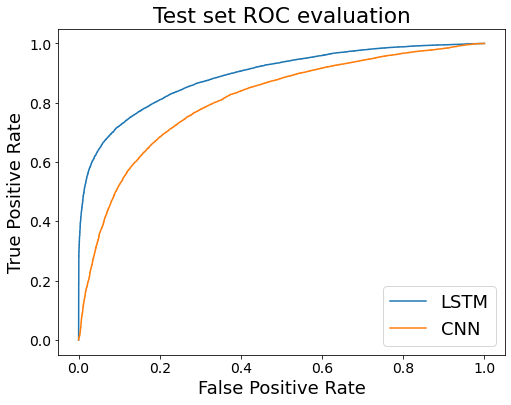

In [ ]:
# plot TPR vs FPR
rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8,6))
plt.tick_params(labelsize=14)
plt.plot(fpr,tpr) 
# plt.plot(fpr2,tpr2) 
plt.plot(fpr3,tpr3) 
plt.title('Test set ROC evaluation')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(['LSTM', 'CNN'])
plt.show()

# Plot UMAP projection of LSTM embedding
Reload saved model if needed

In [ ]:
# model = K.models.load_model("/content/gdrive/My Drive/BMI707 Project/LSTM_model/")

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 514       
Total params: 1,150,886
Trainable params: 1,150,886
Non-trainable params: 0
_________________________________________________

Visualize output of LSTM layer (document embedding)

In [ ]:
n_points = 1000
embedding_model = K.Model(model.input, model.get_layer('lstm_1').output)
doc_embeddings = embedding_model.predict(X_train[:n_points, :])
print(doc_embeddings.shape)

(1000, 128)


In [ ]:
reducer = umap.UMAP()
doc_umap = reducer.fit_transform(doc_embeddings)

In [ ]:
embedding_df = pd.DataFrame({
    'D1': doc_umap[:, 0],
    'D2': doc_umap[:, 1],
    'Label': ["Sepsis" if label==1 else "No sepsis" for 
              label in y_train[:n_points, 1] ]
})

fig = px.scatter(embedding_df, x="D1", y="D2", color='Label', 
                 color_discrete_map={"Sepsis": "red", "No sepsis": "blue"},
                 width=1000, height=750,
                 title="UMAP of LSTM embeddings (n=1000 training instances)")
fig.show()